In [21]:
# Solution to problem set 1   course Building a Robot Judge  Prof E Ash ETHZ  due date 21 Mar 2019  submitted by Heman Tanos tanosh@student.ethz.ch

In [196]:
import numpy as np

import csv
import pandas as pd
import os
from datetime import time 
from datetime import datetime
import matplotlib.pyplot as plt

from string import punctuation
translator = str.maketrans(' ', ' ', punctuation)
from nltk.corpus import stopwords
stoplist = set(stopwords.words('english'))
from nltk.stem import SnowballStemmer
stemmer = SnowballStemmer('english')


In [197]:
def normalize_text(doc):                # taken from past problem set     see comment under question 3
    tokens = []
    for sent in doc.sents:
        sent = str(sent)
        sent = sent.replace('\r', ' ').replace('\n', ' ') 
        lower = sent.lower()
        nopunc = lower.translate(translator)
        words = nopunc.split()
        nostop = [w for w in words if w not in stoplist]
        no_numbers = [w if not w.isdigit() else '#' for w in nostop]
        stemmed = [stemmer.stem(w) for w in no_numbers]
        tokens += stemmed
    return tokens


In [198]:
df = pd.DataFrame(index = range(0,0), columns=['jahr',  'rev', 'nsents', 'nwords', 'nlets', 'nnouns', 'nverbs', 'nadjes', 'tgs'], 
                  dtype = int)
df['tgs'] = df['tgs'].astype('object')  # tgs is a list of trigrams

fpath = '/home/xhta/Robot/cases'   # !!!!!! this path must be modified to point to the folder where the cases are located (texts)

lrev = []	#list of reversed cases   
lnrev = []	#list of not reversed cases

print ("reading in cases_reversed.txt")
with open ("/home/xhta/Robot/cases_reversed.txt") as fcrev:
    readCSV = csv.reader(fcrev, delimiter = ',')
    next(readCSV, None)   # skip 1 line   don't skip in case of 96  only skip in the orig
    for Zei in readCSV:
        if (Zei[1] == '0'): lnrev.append(Zei[0])
        else: lrev.append(Zei[0])

print ("done reading in cases_reversed.txt")

reading in cases_reversed.txt
done reading in cases_reversed.txt


In [207]:
n_samples = 300   # !!!!!!!!!!!!!!!!!!! to be set from run to run !!!!!!!!!   1000 was suggested in the problem set
# run time is long when setting n_samples to 1000 (1 hour)
n_rev = len(lrev)  # the n_samples samples are composed in the same proportion of reversed/nonreversed cases as in the full corpus
n_nrev = len(lnrev)
n_all = n_rev + n_nrev

n_samples_rev = int(np.ceil(n_samples * n_rev/n_all))
n_samples_nrev = n_samples - n_samples_rev

samples_rev_caseid = np.random.choice(lrev, n_samples_rev, replace = False)
samples_nrev_caseid = np.random.choice(lnrev, n_samples_nrev, replace = False)

for caseid_nrev in samples_nrev_caseid:     # populate the index with the case ID  and the column 'rev' 
    df.loc[caseid_nrev] = [0, 0, 0, 0, 0, 0, 0, 0, [ ]]

for caseid_rev in samples_rev_caseid:
    df.loc[caseid_rev] = [0, 1, 0, 0, 0, 0, 0, 0, [ ]]

print ("done inserting caseid and rev into dataframe")

from os import listdir
from os.path import isfile, join

fnames = [f for f in listdir(fpath) if isfile(f)]

ldir = listdir(fpath)


done inserting caseid and rev into dataframe


In [203]:
import spacy                   #  initializing data structures used later
from spacy.lang.en import English
nlp = English()
nlp.add_pipe(nlp.create_pipe('sentencizer'))

nlp2 = spacy.load('en_core_web_sm')

from nltk import ngrams
from collections import Counter
term_frequencies = Counter()

totalgrams = []

i = 0

In [ ]:
for fname in ldir:            # read in the document samples and populate the dataframe
    lae = len(fname)
    cname = fname[5:(lae-4)]
    year = fname[0:4]
    if (not (cname in df.index)): continue

    if ( i% 199 ==0):
        print(datetime.now().strftime('%Y%m%d_%H:%M:%S'))   # serves as a "progress bar" when reading in a large # of docs
    df.at[cname, 'jahr'] =  year
    i = i + 1
    fna2 = join(fpath, year + '_' + cname + '.txt')
    rawtext = open(fna2).read()
    doc = nlp(rawtext)
    df.at[cname, 'nlets'] =  len(rawtext)
    sentences = [sent.string.strip() for sent in doc.sents]
    df.at[cname, 'nsents'] =  len(sentences)
    df.at[cname, 'nwords'] = len([token for token in doc if not token.is_punct])
    doc2 = nlp2(rawtext)
    df.at[cname, 'nnouns'] = len([w for w in list(doc2) if w.tag_.startswith('N')]) # PTB convention
    df.at[cname, 'nverbs'] = len([w for w in list(doc2) if w.tag_.startswith('V')])
    df.at[cname, 'nadjes'] = len([w for w in list(doc2) if w.tag_.startswith('J')])
    cltoks = normalize_text(doc2)
    ntoks = [str(token).lower() for token in list(doc2) if (token.tag_.startswith('N')) & (not token.is_punct) & (not token.is_space) & (not token.is_stop) & (str(token) in cltoks)]
    trigrams = ngrams(cltoks, 3)
    grams = []
    for t in trigrams:
        lt = list(t)
        if(lt[2] in ntoks): grams += ['_'.join(t)]
    df.at[cname, 'tgs'] = grams
    totalgrams += grams
    term_frequencies.update(cltoks)

print ("finished populating data frame")

20190320_01:13:04
20190320_01:24:21
20190320_01:33:45
20190320_01:52:34


In [ ]:
# Question 1 : historgrams
df['nsents'].hist(bins=50, color = 'green', alpha = 0.9)    # histogram over number of sentences
df['nsents'].plot(kind='kde')
plt.show()

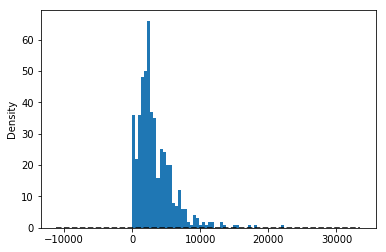

In [67]:
df['nwords'].hist(bins=50)    # histogram over number of words
df['nwords'].plot(kind='kde', style = 'k--')

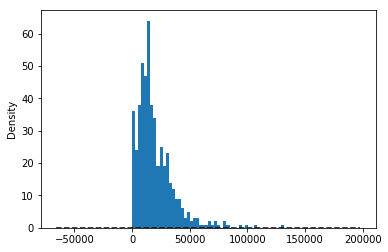

In [68]:
df['nlets'].hist(bins=50)    # histogram over number of letters
df['nlets'].plot(kind='kde', style = 'k--')

In [ ]:
df.head()

In [101]:
# Question 2 number of nouns/verbs/adjectives in document 
#  documents are indexed by their respective caseid
#  number of nouns in document with case id  X2S1O7 is df.loc['X2S1O7', 'nnouns']  analogous with verbs/adjectives

# aggregate by year to plot the frequencies 
df.groupby('jahr')['rev', 'nsents', 'nwords', 'nlets', 'nnouns', 'nverbs', 'nadjes'].sum()

,rev,nsents,nwords,nlets,nnouns,nverbs,nadjes
jahr,,,,,,,
1924.0,0.0,77.0,3012.0,16753.0,892.0,445.0,176.0
1925.0,1.0,30.0,732.0,4099.0,225.0,103.0,18.0
1926.0,2.0,275.0,8238.0,45742.0,2480.0,1102.0,362.0
1927.0,4.0,367.0,9482.0,53366.0,2722.0,1398.0,488.0
1928.0,0.0,59.0,1436.0,7841.0,433.0,222.0,56.0
1929.0,0.0,195.0,4311.0,23459.0,1394.0,496.0,231.0
1930.0,1.0,242.0,5300.0,29242.0,1687.0,808.0,199.0
1931.0,1.0,219.0,5270.0,28891.0,1612.0,745.0,265.0
1932.0,3.0,835.0,26508.0,148720.0,8095.0,3390.0,1235.0


In [190]:
gby = df.groupby('jahr')['rev', 'nsents', 'nwords', 'nlets', 'nnouns', 'nverbs', 'nadjes'].sum()

<Figure size 432x288 with 0 Axes>

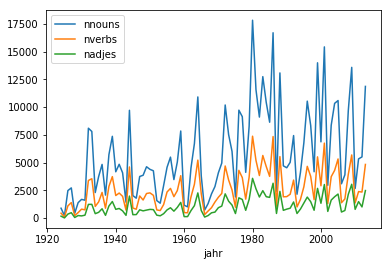

In [179]:
# still Question 2 : plot the frequencies of nouns, verbs and adjectives by year
plt.clf()
df.groupby('jahr')['nnouns', 'nverbs', 'nadjes'].sum().plot(kind='line')
plt.show()

In [ ]:
# Question 3 : normalization to remove noise because noise distorts the statistics
# CR anf LF are replaced by spaces because readCSV appends CR anf LF to the end of a line
# further, punctuation marks and stopwords are onsidered noise and removed
# last, words are stemmed   e.g. works, worked, working --> work, boy, boys, boy's -> boy

In [132]:
# Question 4. df3 is a new dataframe with 1000 trigrams as features (the trigrams end with a noun)
n_feats = 1000          # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
from collections import Counter
tgc = Counter(totalgrams)
mc = tgc.most_common()[0:n_feats]
lmc = len(mc)

# df3 includes the targets/labels because need to do logisticregression later
feats = ['rev']
for j in range(lmc):
    tu = tgc.most_common()[j]
    fea = tu[0]
    feats.append(fea)

df3 = pd.DataFrame(index = df.index, columns=feats, dtype = int)
df3['rev'] = df['rev']
df3 = df3.astype({"rev": int})
pkl_fname = 'df3.' + datetime.now().strftime('%Y%m%d_%H%M%S' + ".pkl")
#df3.to_pickle(pkl_fname)
# save a a pickle for later use

In [133]:
for loca in df.index:
    tgs = df.loc[loca, 'tgs']
    for feat in feats:
        if (feat == 'rev'): continue
        df3.at[loca, feat] = tgs.count(feat)

In [191]:
 # elapse time  starttime = time.time()     elapsed time = time.time() - starttime
# Question 5: apply LogisticRegression from sklearn on the training data set and make prediction
# using teh traing / test data set to compare the accuracy scoe / the F1 score

from sklearn import preprocessing

target = df3['rev']
features = df3.loc[:,df3.columns != 'rev']

features_scaled = preprocessing.scale(features, with_mean=False)
msk = np.random.rand(len(df3)) < 0.8      
# split into 80 % training set and 20% test set

# training set
targeta = target[msk]
feata = features_scaled[msk]

# test set
targete = target[~msk]
feate = features_scaled[~msk]

from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state = 123, solver = 'liblinear').fit(feata, targeta)

ypreda = clf.predict(feata)
yprede = clf.predict(feate)
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
  # accuracy on training data
  # accuracy on test data
print(accuracy_score(targeta, ypreda), accuracy_score(targete, yprede))
# print out accuracy when predicting using the training set vs when using the test set

0.9759036144578314 0.5764705882352941


In [110]:
  # print out F1 when using training data to predict vs when usinh test data to predict
print(f1_score(targeta, ypreda), f1_score(targete, yprede) )


0.8098591549295775 0.7067669172932332


In [193]:
confusion_matrix(targeta, ypreda)  # cm on training data

array([[143,  10],
       [  0, 262]])

In [194]:
confusion_matrix(targete, yprede)  # cm on test data

array([[ 8, 22],
       [14, 41]])

In [195]:
# Question 6
#from sklearn import grid_search, # deprecated
from sklearn import model_selection
parameters = {'penalty':('l1', 'l2'), 'C':[1, 2, 5, 10]}

#clf2 = grid_search.GridSearchCV(clf, parameters)
#clf2.fit(feata, targeta)
#clf2.best_params_

clf3 = model_selection.GridSearchCV(clf, parameters)
clf3.fit(feata, targeta)
clf3.best_params_

{'C': 1, 'penalty': 'l1'}

In [29]:
# Question 7 
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *
from nltk.sentiment.vader import SentimentIntensityAnalyzer

#for fname in ldir[0:10]:
for fname in ldir:
    lae = len(fname)
    cname = fname[5:(lae-4)]
    year = fname[0:4]
    fna2 = join(fpath, year + '_' + cname + '.txt')
    rawtext = open(fna2).read()
    #doc = nlp(rawtext)
    #doc2 = nlp2(rawtext)
    sid = SentimentIntensityAnalyzer()
    ss = sid.polarity_scores(rawtext)
    for k in sorted(ss):
        print('{0}:{1}, '.format(k, ss[k]), end='')
    print()


from sklearn.feature_extraction.text import TfidfVectorizer

dfvec = pd.DataFrame(index = range(0,0), columns=['jahr',  'rev', 'text', 'tgs'], dtype = int)
dfvec['jahr'] = df['jahr']
dfvec['rev'] = df['rev']
dfvec['tgs'] = df['tgs']
dfvec['text'] = dfvec['text'].astype('object')
dfvec['rev'] = dfvec['rev'].astype('int')

for fname in ldir:
    lae = len(fname)
    cname = fname[5:(lae-4)]
    year = fname[0:4]
    if (not (cname in df.index)): continue
    fna2 = join(fpath, year + '_' + cname + '.txt')
    rawtext = open(fna2).read()
    #nlp3 = spacy.load('en')
    #doc = nlp3(rawtext)
    #sentences = [sent.string.strip() for sent in doc.sents]
    #doc2 = nlp2(rawtext)
    dfvec.at[cname, 'text'] = rawtext

vec = TfidfVectorizer(min_df = 0.001, max_df = 0.8, max_features = 4000, stop_words = 'english', use_idf = True, ngram_range = (1,3))
vec = TfidfVectorizer(min_df = 0.0001, max_df = 0.4, max_features = 40000, stop_words = 'english')
trainedVec = vec.fit_transform (dfvec['text'])

from sklearn.metrics.pairwise import cosine_similarity

# compute cosine similarity between sentences
cs = cosine_similarity(trainedVec[0:1000], trainedVec)




20190319_14:34:45
20190319_14:35:04
20190319_14:35:21
20190319_14:35:36
20190319_14:35:52
20190319_14:36:09
20190319_14:36:27
20190319_14:36:40
20190319_14:36:52
20190319_14:37:07
20190319_14:37:20
20190319_14:37:39
20190319_14:37:57
20190319_14:38:12
20190319_14:38:25
20190319_14:38:45
20190319_14:39:02
20190319_14:39:17
20190319_14:39:33
20190319_14:39:48
20190319_14:40:04
20190319_14:40:14
20190319_14:40:44
20190319_14:41:10
20190319_14:41:28
20190319_14:41:45
20190319_14:42:18
20190319_14:42:36
20190319_14:42:47
20190319_14:43:03
20190319_14:43:20
20190319_14:43:33
20190319_14:43:46
20190319_14:44:14
20190319_14:44:26
20190319_14:44:43
20190319_14:44:58
20190319_14:45:14
20190319_14:45:32
20190319_14:45:50
20190319_14:46:08
20190319_14:46:22
20190319_14:47:09
20190319_14:47:33
20190319_14:47:54
20190319_14:48:13
20190319_14:48:34
20190319_14:48:51
20190319_14:49:08
20190319_14:49:24
20190319_14:49:45
20190319_14:50:00
20190319_14:50:20
20190319_14:50:46
20190319_14:51:15
20190319_1

In [32]:
from sklearn.cluster import KMeans
km = KMeans(n_clusters = 10, n_jobs = -1)

km.fit(cs)


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=10, n_init=10, n_jobs=-1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [33]:
doc_cl = km.labels_.tolist()

In [34]:
len(doc_cl)

500

In [38]:
type(doc_cl)

list

In [39]:
len(doc_cl[0])

TypeError: object of type 'int' has no len()

In [41]:
doc_cl[0:10]

[4, 6, 9, 4, 4, 0, 6, 2, 8, 8]